In [1]:
import os
from pathlib import Path
import requests
from dotenv import load_dotenv
from pydantic import BaseModel, Field
from typing import Any, Dict, List, Optional, Union, Annotated
from typing_extensions import Literal, TypedDict
from enum import Enum
from langchain_core.messages import HumanMessage, SystemMessage, ToolMessage
from langchain_core.tools import tool
from langchain.chat_models import init_chat_model
from langgraph.graph import MessagesState, StateGraph, START, END
from googleapi_tool import TravelAssistant
from weather_tool import interpret_weather_code, get_weather
from event_tools import get_events_with_descriptions, EventScraperTool
from IPython.display import Image, display
from langchain.tools import Tool
from langgraph.checkpoint.memory import MemorySaver

In [2]:
llm = init_chat_model("gpt-4.1-mini", temperature=0.1) 
dotenv_path = Path(".env")
load_dotenv(dotenv_path=dotenv_path)

True

In [11]:
@tool
def nearby_place_search(
    lat: Annotated[float, "Latitude coordinate (-90 to 90)"],
    lng: Annotated[float, "Longitude coordinate (-180 to 180)"],
    topics: Annotated[str, "Search keywords (e.g., 'restaurants', 'hotels', 'attractions')"],
    radius: Annotated[Optional[int], "Search radius in meters (default: 1000)"] = 1000,
    max_places: Annotated[Optional[int], "Maximum number of places to return (default : 10)"] = 10,
    open_now: Annotated[Optional[bool], "Only return places open now (default: True)"] = True
) -> Dict[str, Any]:
    """
    Search for nearby places using Google Places API.
   
    Returns a dictionary containing information about nearby places including
    names, ratings, addresses, and other relevant details. Always keep the default
    values for radius, max_places, and open_now unless the user have specific needs.
    """
    try:
        api_key = os.getenv('GOOGLE_API')
        if not api_key:
            return {"error": "Google API key not found in environment variables"}
       
        assistant = TravelAssistant(api_key)
        result = assistant.find_nearby_places(
            lat=lat,
            lng=lng,
            topics=topics,
            radius=radius,
            max_places=max_places,
            open_now=open_now
        )
        return result
    except Exception as e:
        return {"error": f"Failed to search nearby places: {str(e)}"}


@tool
def get_weather(latitude: float, longitude: float) -> Dict[str, Any]:
    """
    Get the current weather data for a given latitude and longitude using Open-Meteo API.
    """
    endpoint_url = "https://api.open-meteo.com/v1/forecast"
    params = {
        'latitude': latitude,
        'longitude': longitude,
        'current_weather': True,
        'temperature_unit': 'celsius',
        'windspeed_unit': 'kmh',
        'timezone': 'auto'
    }

    response = requests.get(endpoint_url, params=params)
    weather_data = response.json()

    if response.status_code == 200:
        current_weather = weather_data.get('current_weather', {})
        return {
            "time_observed": current_weather.get('time'),
            "temperature_celsius": current_weather.get('temperature'),
            "windspeed_kmh": current_weather.get('windspeed'),
            "wind_direction_degrees": current_weather.get('winddirection'),
            "weather_description": interpret_weather_code(current_weather.get('weathercode')),
            "is_day": current_weather.get('is_day') == 1
        }
    else:
        return {
            "error": weather_data.get('error', 'Unknown error'),
            "status_code": response.status_code
        }

@tool
def get_detailed_events_tool(city: str, category: str, max_events: int = 10) -> dict:
    """
    Retrieve detailed event listings for a given city and category.
    Do this when the user asks for events in a specific city and category.If not specified, ask the user for the category.

    Args:
        city (str): The name of the city (e.g., "Berlin").
        category (str): Event category. One of: disco, konzert, theater, medien, 
                        sonstige, kino, literatur, comedy, vortrag, kunst.
        max_events (int, optional): Maximum number of events to return (default is 5).

    Returns:
        dict: A structured dictionary containing city, category, and a list of event data, 
              or an error message if the request fails.

    Example return:
        {
            "city": "Berlin",
            "category": "konzert",
            "total_events": 10,
            "events": [
                {
                    "id": 1,
                    "title": "Jazz Night",
                    "date_time": "15.06.2025, 20:00",
                    "location": "A-Trane",
                    "description": "A night of smooth jazz with local bands.",
                    "event_url": "https://example.com/event1"
                },
                ...
            ]
        }
    """
    detailed_events = get_events_with_descriptions(
        city=city,
        category=category,
        max_events=max_events,
        force_refresh=True
    )

    if isinstance(detailed_events, dict) and 'error' in detailed_events:
        return {"error": detailed_events["error"]}

    return {
        "city": city,
        "category": category,
        "total_events": len(detailed_events),
        "events": [
            {
                "id": i + 1,
                "title": event["title"],
                "date_time": event["date_time"],
                "location": event["location"],
                "description": event["description"],
                "event_url": event.get("event_url", "")
            }
            for i, event in enumerate(detailed_events)
        ]
    }

@tool
def get_available_event_categories(city: str) -> Union[Dict[str, Union[str, Dict[str, int]]], Dict[str, str]]:
    """
    Retrieve all available event categories in a given city along with the number of events in each category.
    Do this when the user asks for available event categories in a specific city.

    Args:
        city (str): Name of the city to search for events (e.g., "Berlin").

    Returns:
        dict: A dictionary with:
            - `city`: Name of the city
            - `available_categories`: A mapping of category names to the number of events
        Or, if an error occurs:
            - `error`: Description of the error

    Example return:
        {
            "city": "Berlin",
            "available_categories": {
                "konzert": 12,
                "theater": 7,
                "kino": 9,
                "kunst": 5
            }
        }
    """
    try:
        categories = EventScraperTool.get_available_categories(city)
        if not categories:
            return {"error": f"No event categories found for {city}"}
        
        return {
            "city": city,
            "available_categories": categories
        }
    
    except Exception as e:
        return {"error": str(e)}

In [12]:
tools = [nearby_place_search, get_weather,get_detailed_events_tool, get_available_event_categories]
tools_by_name = {tool.name: tool for tool in tools}
llm_with_tools = llm.bind_tools(tools)

In [19]:
def llm_call(state: MessagesState) -> dict:
    """LLM decides whether to call a tool or not."""

    system_prompt = """You are a helpful travel assistant that helps users find information about places, weather, and events.

TOOL SELECTION GUIDELINES:
- Use nearby_place_search when users ask for restaurants, cafes, or places to eat in a specific location
- Use get_weather when users ask about weather conditions, forecasts, or weather-related travel advice
- Use get_detailed_events_tool when users ask about specific events in a city (requires both city and category)
- Use get_available_event_categories when users want to know what types of events are available in a city

TOOL-SPECIFIC INSTRUCTIONS:

nearby_place_search:
- Select top 3 restaurants based on ratings (prefer 4.0+ stars) and review count
- For each place, provide:
  * Name
  * Rating (with review count if available)
  * Price_Level ($ to $$$$)
  * Concise summary (3-4 sentences) highlighting cuisine type, atmosphere, and standout features from reviews
  * Google_Maps_Link
- If fewer than 3 results, explain why and provide what's available
- If no results found, suggest nearby areas or alternative search terms

get_weather:
- Accept various location formats (city, coordinates, landmarks)
- If location is ambiguous, ask for clarification
- Provide weather summary including:
  * Current conditions and temperature
  * Relevant forecast (today/tomorrow/trip dates)
  * Travel-relevant advice (what to wear, activities to avoid/enjoy)
- Handle weather API failures gracefully by explaining the issue

get_detailed_events_tool:
- Requires both city AND category - if either is missing, ask specifically for the missing information
- If user provides an invalid category, first call get_available_event_categories to show options
- Validate city name format before making the call
- From the events returned, choose the top 3 based on the users input. For example if the user ask for jazz events, search for concerts and choose the top 3 jazz concerts.
- If no events found, suggest alternative dates, nearby cities, or different categories

get_available_event_categories:
- Requires city name - if not provided, ask for it
- Present categories in a user-friendly format (numbered list or bullets)
- If city not found, suggest similar city names or ask for clarification

GENERAL GUIDELINES:
- Always validate user inputs before making tool calls
- If a tool call fails, explain what went wrong and suggest alternatives
- Maintain conversation context - remember previous searches and preferences
- If user asks follow-up questions about previous results, reference them directly
- For ambiguous requests, ask clarifying questions before making assumptions
- If multiple tools could apply, ask which aspect they're most interested in
- Always provide helpful context and suggestions beyond just raw tool output

ERROR HANDLING:
- If tool returns empty results, explain why and suggest alternatives
- If tool fails due to invalid input, explain the issue and ask for corrected information
- If technical errors occur, acknowledge the problem and offer to try again or use alternative approaches

CONVERSATION FLOW:
- Remember previous tool results within the conversation
- Build on previous searches (e.g., "restaurants near the hotel you mentioned")
- Offer related suggestions (e.g., after weather, suggest appropriate activities)
- Ask if user needs more information or has related questions
"""

    return {
        "messages": [
            llm_with_tools.invoke(
                [SystemMessage(content=system_prompt)] + state["messages"]
            )
        ]
    }

def tool_node(state: dict):
    """Performs the tool call"""

    result = []
    for tool_call in state["messages"][-1].tool_calls:
        tool = tools_by_name[tool_call["name"]]
        observation = tool.invoke(tool_call["args"])
        result.append(ToolMessage(content=observation, tool_call_id=tool_call["id"]))
    return {"messages": result}


def should_continue(state: MessagesState) -> Literal["environment", END]:
    """Decide if we should continue the loop or stop based upon whether the LLM made a tool call"""

    messages = state["messages"]
    last_message = messages[-1]
    if last_message.tool_calls:
        return "Action"
    return END

In [20]:
agent_builder = StateGraph(MessagesState)

# Add nodes
agent_builder.add_node("llm_call", llm_call)
agent_builder.add_node("environment", tool_node)

# Add edges to connect nodes
agent_builder.add_edge(START, "llm_call")
agent_builder.add_conditional_edges(
    "llm_call",
    should_continue,
    {
        # Name returned by should_continue : Name of next node to visit
        "Action": "environment",
        END: END,
    },
)
agent_builder.add_edge("environment", "llm_call")
memory = MemorySaver()
# Compile the agent
agent = agent_builder.compile(checkpointer=memory)

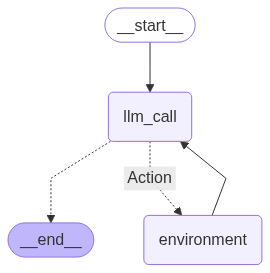

In [21]:
display(Image(agent.get_graph(xray=True).draw_mermaid_png()))

In [22]:
config = {"configurable": {"thread_id": "1"}}
messages = [HumanMessage(content="Look for some jazz event in Berlin today")]
messages = agent.invoke({"messages": messages},config=config)
for m in messages["messages"]:
    m.pretty_print()

Scraping fresh data for Berlin...
Fetching descriptions for 3 events...
Fetching description 1/3: Konzert: Citadel Music Festival* link...
Fetching description 2/3: Konzert: Pop-Up Session – Isaac Jensen & KAZMSlink...
Fetching description 3/3: Umsonst & Draußen: Spandauer Liedertag 2025link...
================================ Human Message =================================

Look for some jazz event in Berlin today
================================== Ai Message ==================================

To find jazz events in Berlin today, I will first check the available event categories in Berlin to confirm if jazz events are listed under a specific category such as concerts. Then I will look for events in that category.
Tool Calls:
  get_available_event_categories (call_WBTR0icfw6ax7ZUqIE5Vi9BQ)
 Call ID: call_WBTR0icfw6ax7ZUqIE5Vi9BQ
  Args:
    city: Berlin
================================= Tool Message =================================

{'city': 'Berlin', 'available_categories': {'konzer